# Produce Sky flats


- Creation : Tuesday 2016 June 7th
- Update : Wednesday 2016th June 22
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-22 11:28:32.602355
fits date format for the analysis :  2016-06-22T11:28:32


In [5]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

## 1) Get the master bias 

In [6]:
path='.'
basefilename='masterbias_ostrim_1.fits' # check master bias
#basefilename='masterdarkscaled_ostrim_1.fits' # check master dark
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2

In [7]:
allbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allbias.append(ccd_chan)

In [8]:
mbheader=allbias[0].header
mbheader['DATE-ANA']=date_of_analysis

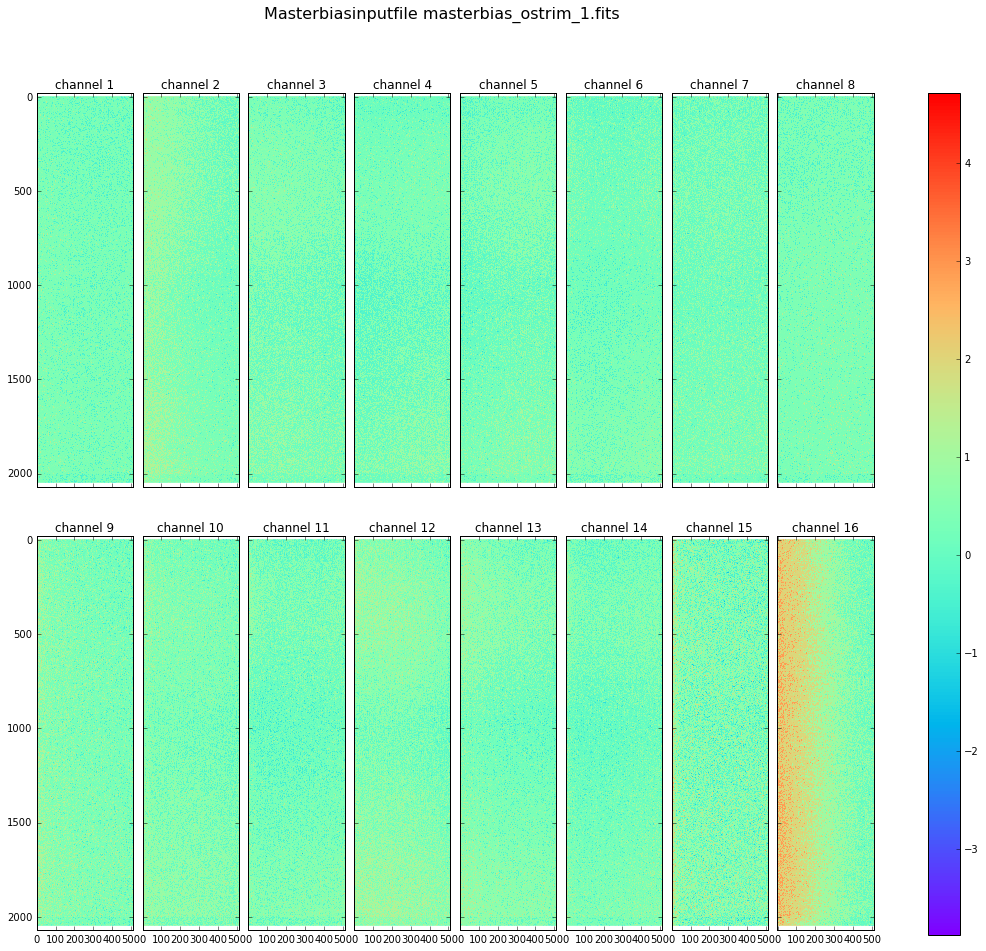

In [9]:
#libMonocamBaseImages.ShowImagesSet(allbias)
libMonocamBaseImages.ShowImagesSet(allbias,'Masterbias',basefilename,'masterbiases_img.pdf',nbsig=10)

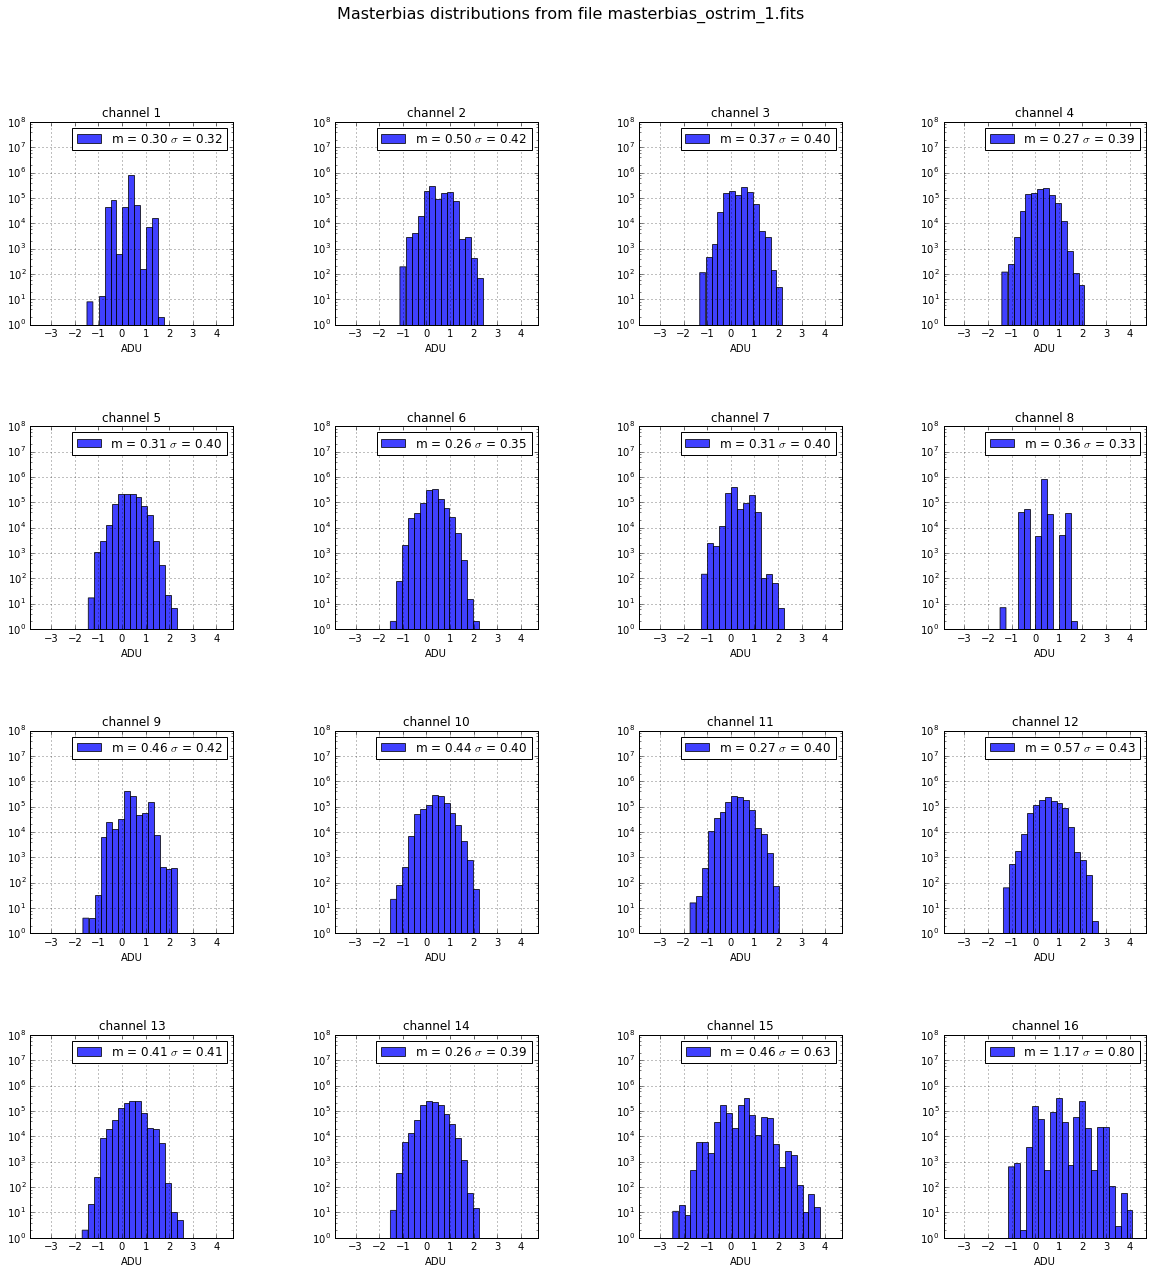

In [10]:
libMonocamBaseImages.ShowHistoSet(allbias,'Masterbias distributions',basefilename,'masterbiases_hist.pdf',nbsig=10)

## 2) Get the scaled darks

In [11]:
path='.'
basefilename='masterdarkscaled_ostrim_1.fits' # check master dark
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2

In [12]:
alldarks = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    alldarks.append(ccd_chan)

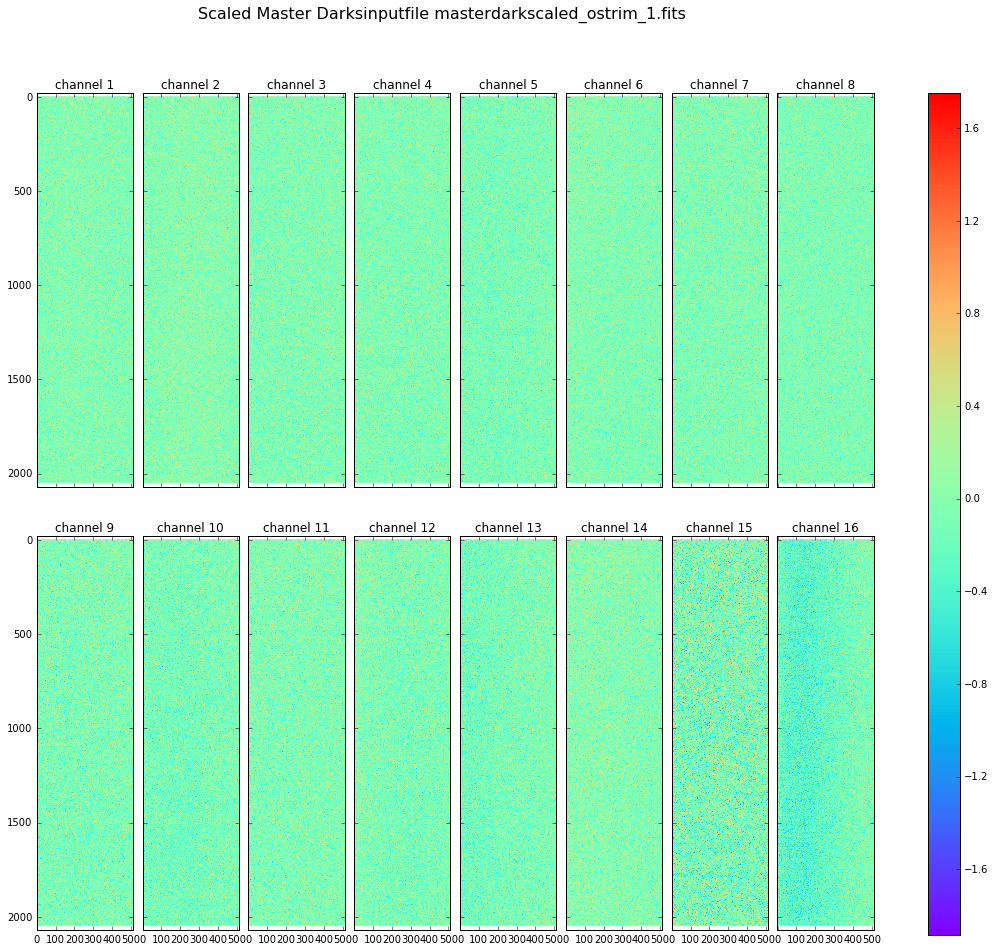

In [13]:
libMonocamBaseImages.ShowImagesSet(alldarks,'Scaled Master Darks',basefilename,'masterdarks_img.pdf',nbsig=10)

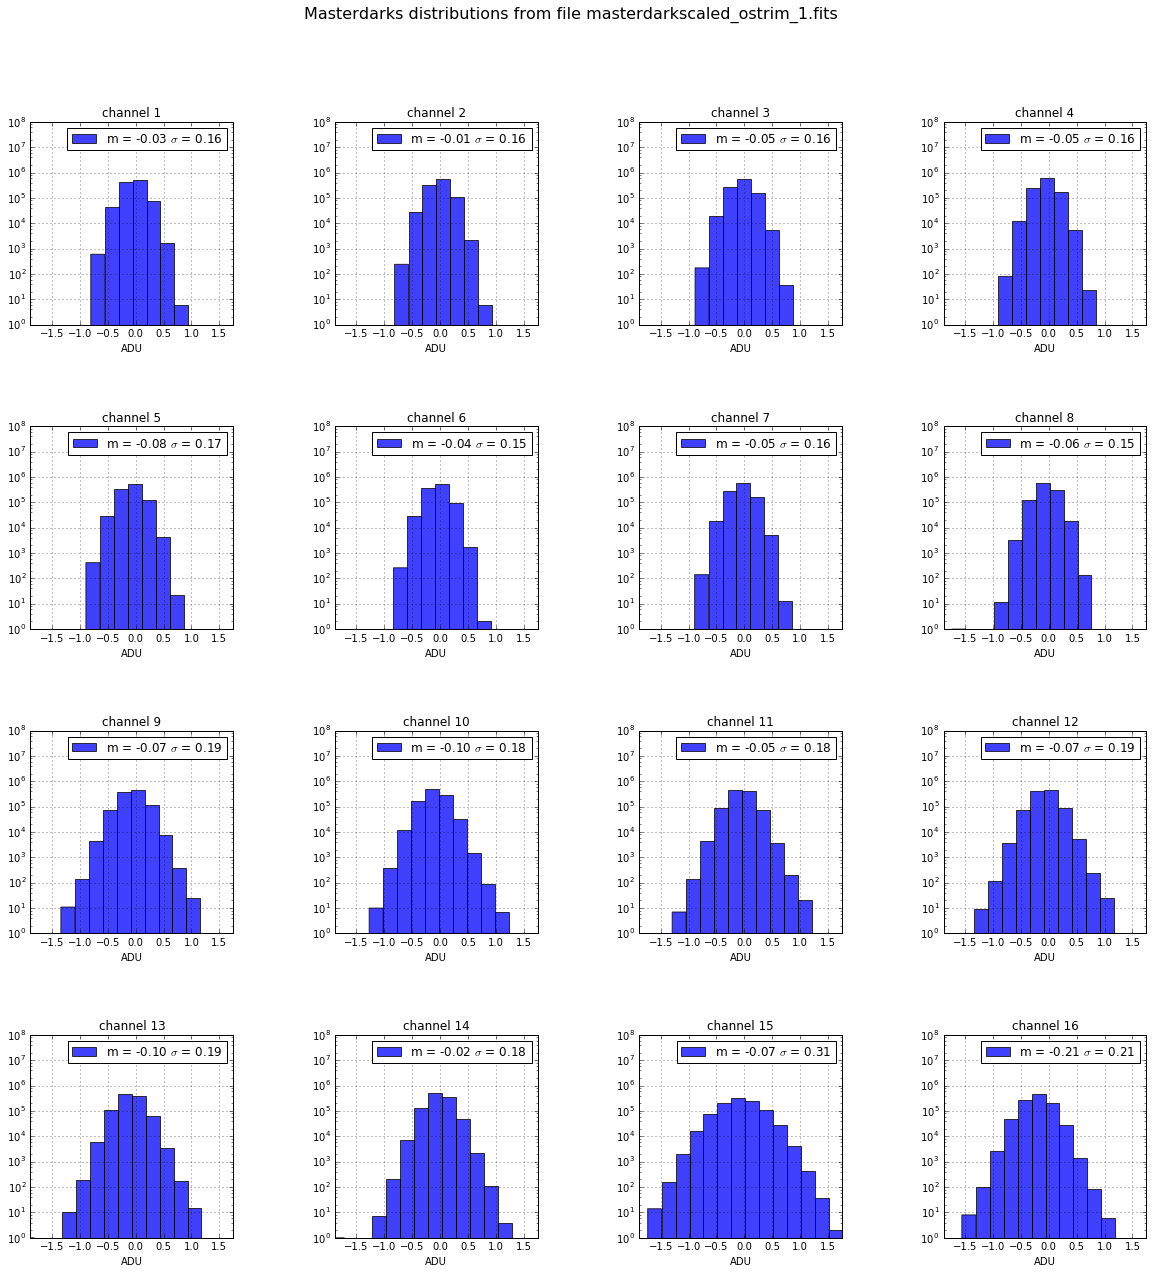

In [14]:
libMonocamBaseImages.ShowHistoSet(alldarks,'Masterdarks distributions',basefilename,'masterdarks_hist.pdf',nbsig=10)

## 3)  Raw sky flats

In [15]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160511'
root_skyflatfilename='skyflats_'
root_skyflatdir='SKYFLAT'
skyflat_startnum=1
skyflat_stopnum=3 
#skyflat_stopnum=40 
image_type='skyflat'

In [16]:
rawskyflat_list=libMonocamBaseImages.BuildFilelist(path,root_skyflatfilename,start=skyflat_startnum,stop=skyflat_stopnum)

In [17]:
NB_OF_SKYFLATS=len(rawskyflat_list)

In [18]:
print NB_OF_SKYFLATS

3


### a) Read the skyflat images

In [19]:
allchannelallskyflat = []  # list of 16 lists of sky-flats 
exposures_list = []        # sequential list of the exposures of the sky flats 
header_list = []           # list of headers

# get the primary block headers:
for image_file in rawskyflat_list: 
    hdu_list = fits.open(image_file)
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    exposures_list.append(exposure)
    header_list.append(header)

# get the CCD images:
for chan in range(1,NB_OF_CHAN_AMPL+1,1): # loop on channel
    fileindex=0
    allskyflat = []  # container of flats for a given channel
    for image_file in rawskyflat_list:       
        ccd_chan = ccdproc.CCDData.read(image_file, hdu=chan,unit="adu")
        allskyflat.append(ccd_chan)  # image extension
        fileindex=fileindex+1
    allchannelallskyflat.append(allskyflat)
        

In [21]:
print 'Number of channels ::',len(allchannelallskyflat)

Number of channels :: 16


### b) Substract overscan and trim

In [22]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

In [23]:
# oscan and trim the image for each channel 
for chan in range(NB_OF_CHAN_AMPL):
    # oscan all the flats for that channel
    libMonocamBaseImages.oscan_and_trim(allchannelallskyflat[chan])

### c) Substract the bias

In [24]:
allchannelsallskyflat_corrbias = []  # list of 16 lists of sky-flats 
for chan in range(NB_OF_CHAN_AMPL):
    allskyflat_corrbias = []  # list of skyflats corrected for bias for a given channel
    for idx, img in enumerate(allchannelallskyflat[chan]):
        bias_substracted=ccdproc.subtract_bias(img,allbias[chan])
        allskyflat_corrbias.append(bias_substracted)
    allchannelsallskyflat_corrbias.append(allskyflat_corrbias)

### d) Substract the dark by scaling with exposure

In [25]:
allchannelsallskyflat_corrdark = []  # list of 16 lists of sky-flats 
for chan in range(NB_OF_CHAN_AMPL):
    allskyflat_corrdark = []
    for idx, img in enumerate(allchannelsallskyflat_corrbias[chan]):
        dark_substracted=ccdproc.subtract_dark(img,alldarks[chan],data_exposure=exposures_list[idx]*u.second,dark_exposure=1*u.second,scale=True)
        allskyflat_corrdark.append(dark_substracted)
    allchannelsallskyflat_corrdark.append(allskyflat_corrdark)

### e) Shows the reordered flats

In [30]:
index=1

In [27]:
def NormalizeTheChannels(ccd,index):
    norm_skyflat_coll = [] 
    for chan in range(NB_OF_CHAN_AMPL):
        normflat=1./np.median(ccd[chan][index].data.flatten())
        ccdflat=ccd[chan][index].multiply(normflat)
        norm_skyflat_coll.append(ccdflat)
    return norm_skyflat_coll

In [31]:
norm_skyflat_coll=NormalizeTheChannels(allchannelsallskyflat_corrdark,index)

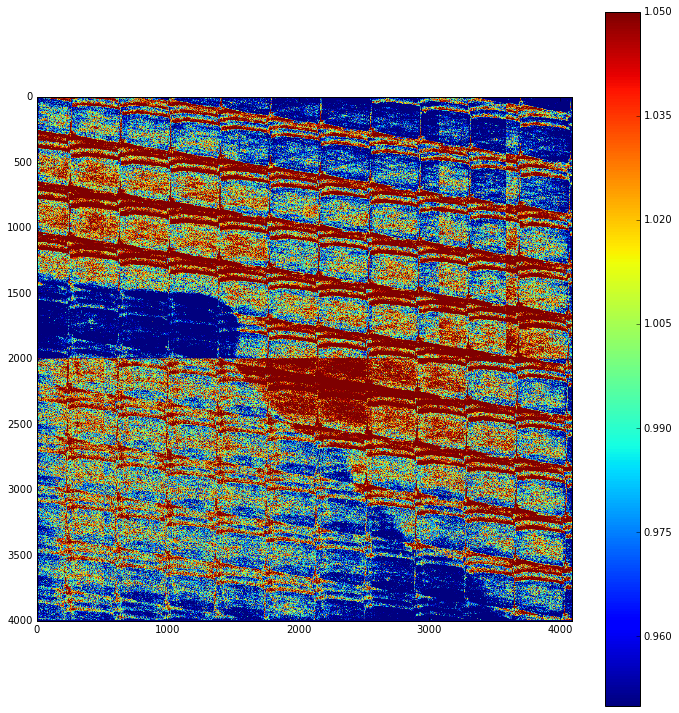

In [32]:
assembledimage=libMonocamBaseImages.MakeSingleImage(norm_skyflat_coll)
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(assembledimage,vmin=0.95,vmax=1.05)
fig.colorbar(img)
plt.tight_layout()

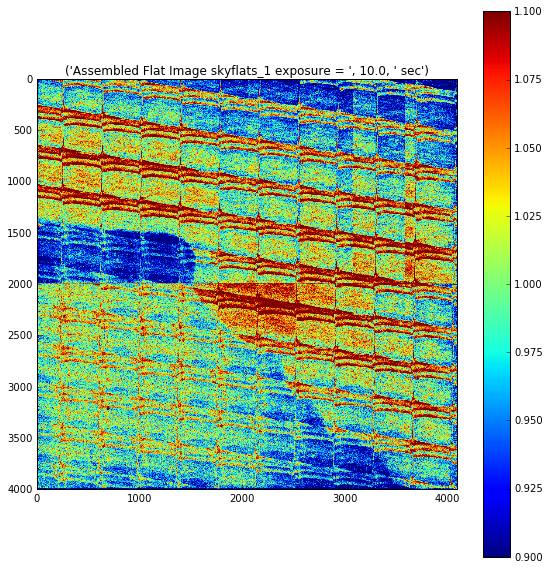

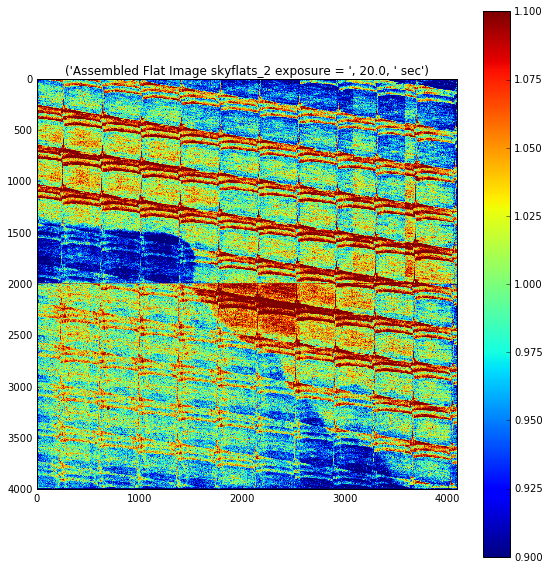

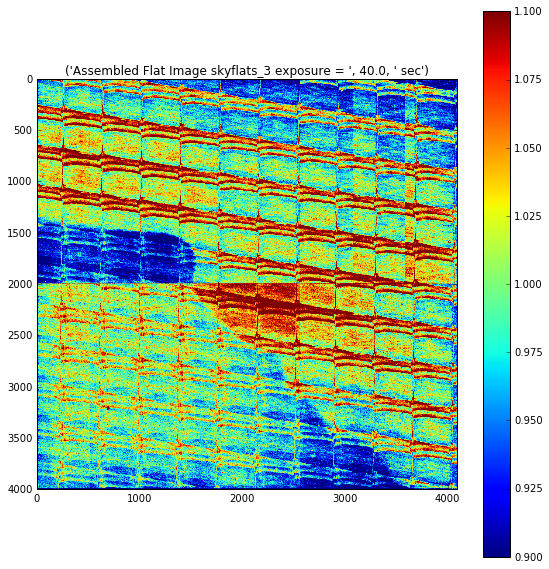

In [34]:
for im in range(NB_OF_SKYFLATS): # loop over fits file images
    image_name='Assembled Flat Image '+root_skyflatfilename+str(im+1)+' exposure = ',exposures_list[im],' sec' #title
    image_filename='AssFlatIm'+root_skyflatfilename+str(im+1)+'.fits' # output fits filename
    fullimage_filename = os.path.join(root_skyflatdir,image_filename) # full output fits filename
    pdfimage_filename='AssFlatIm'+root_skyflatfilename+str(im+1)+'.pdf' # output fits filename
    pdffullimage_filename = os.path.join(root_skyflatdir,pdfimage_filename) # full output fits filename
    # work to get the assembled image
    norm_skyflat_coll=NormalizeTheChannels(allchannelsallskyflat_corrdark,im)
    assembledimage=libMonocamBaseImages.MakeSingleImage(norm_skyflat_coll)
    
    #work on fits file
    hdu=fits.PrimaryHDU(assembledimage)
    hdu.header=header_list[im] # flush the original header into the header of the new image
    hdu.header['OBJECT']=root_skyflatdir
    hdu.header['IMAG_TYP']=image_type
    hdu.header['DATE-ANA']=date_of_analysis  # remember when this sicence image has been produced
    hdu.header['FNAME']=image_filename       # remember the filename   
    hdu.writeto(fullimage_filename,clobber=True)
    
    # wor with figure
    plt.figure(figsize=(8.,8.))
    img=plt.imshow(assembledimage,vmin=0.9,vmax=1.1)
    plt.colorbar(img)
    plt.title(image_name)
    plt.tight_layout()
    plt.savefig(pdffullimage_filename)


### c) Combination, sigma clip and master flat

In [38]:
flat_combiner_list = []
for chan in range(NB_OF_CHAN_AMPL):
    flat_combiner=ccdproc.Combiner(allchannelsallskyflat_corrdark[chan])
    flat_combiner.sigma_clipping(func=libMonocamBaseImages.med_over_images)
    flat_combiner_list.append(flat_combiner)

### d) Generate the Master flat


In [39]:
#scaling_func= lambda arr: 1/np.ma.average(arr)
scaling_func= lambda arr: 1/np.ma.median(arr)

In [40]:
for chan in range(NB_OF_CHAN_AMPL):
    flat_combiner_list[chan].scaling=scaling_func

In [41]:
masterflat_list=[]
for chan in range(NB_OF_CHAN_AMPL):
    masterflat=flat_combiner_list[chan].median_combine(median_func=libMonocamBaseImages.bn_median)
    masterflat.header=allchannelallskyflat[chan][0].meta
    masterflat_list.append(masterflat)

In [42]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

### Save the file

In [43]:
inputfitsfilename=root_skyflatfilename+str(skyflat_startnum)+'-'+str(skyflat_stopnum)+'.fits'
outputfitsfilename='masterflat_'+str(skyflat_startnum)+'-'+str(skyflat_stopnum)+'.fits'
outputfigfilename='masterflat_img'+str(skyflat_startnum)+'-'+str(skyflat_stopnum)+'.pdf'
outputfigfilename2='masterflat_hist'+str(skyflat_startnum)+'-'+str(skyflat_stopnum)+'.pdf'


### Shows the flat

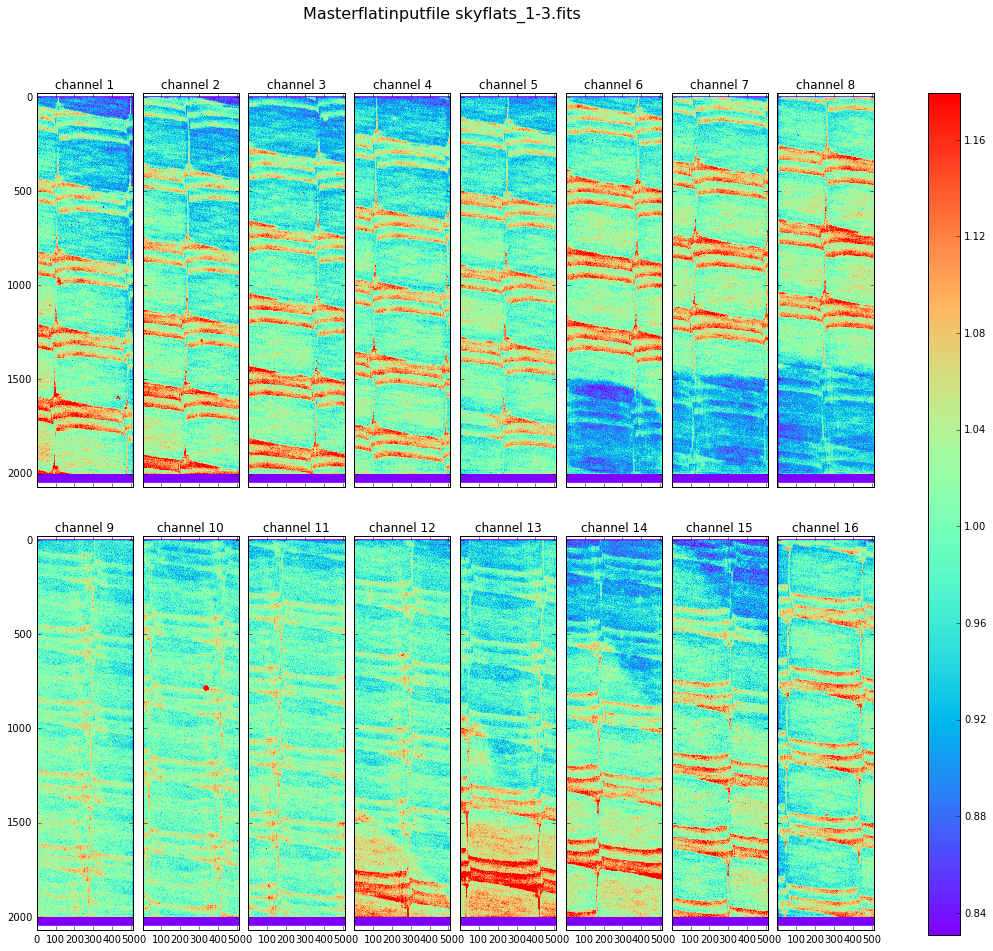

In [44]:
libMonocamBaseImages.ShowImagesSet(masterflat_list,'Masterflat',inputfitsfilename,outputfigfilename,nbsig=3)

### Save master flat

In [45]:
libMonocamBaseImages.SaveCCDListIntoFitsFile(masterflat_list,outputfitsfilename,mbheader,imagetyp='master_flat')

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511, 2048)   float64   
14               Im

### Show the histograms on flats

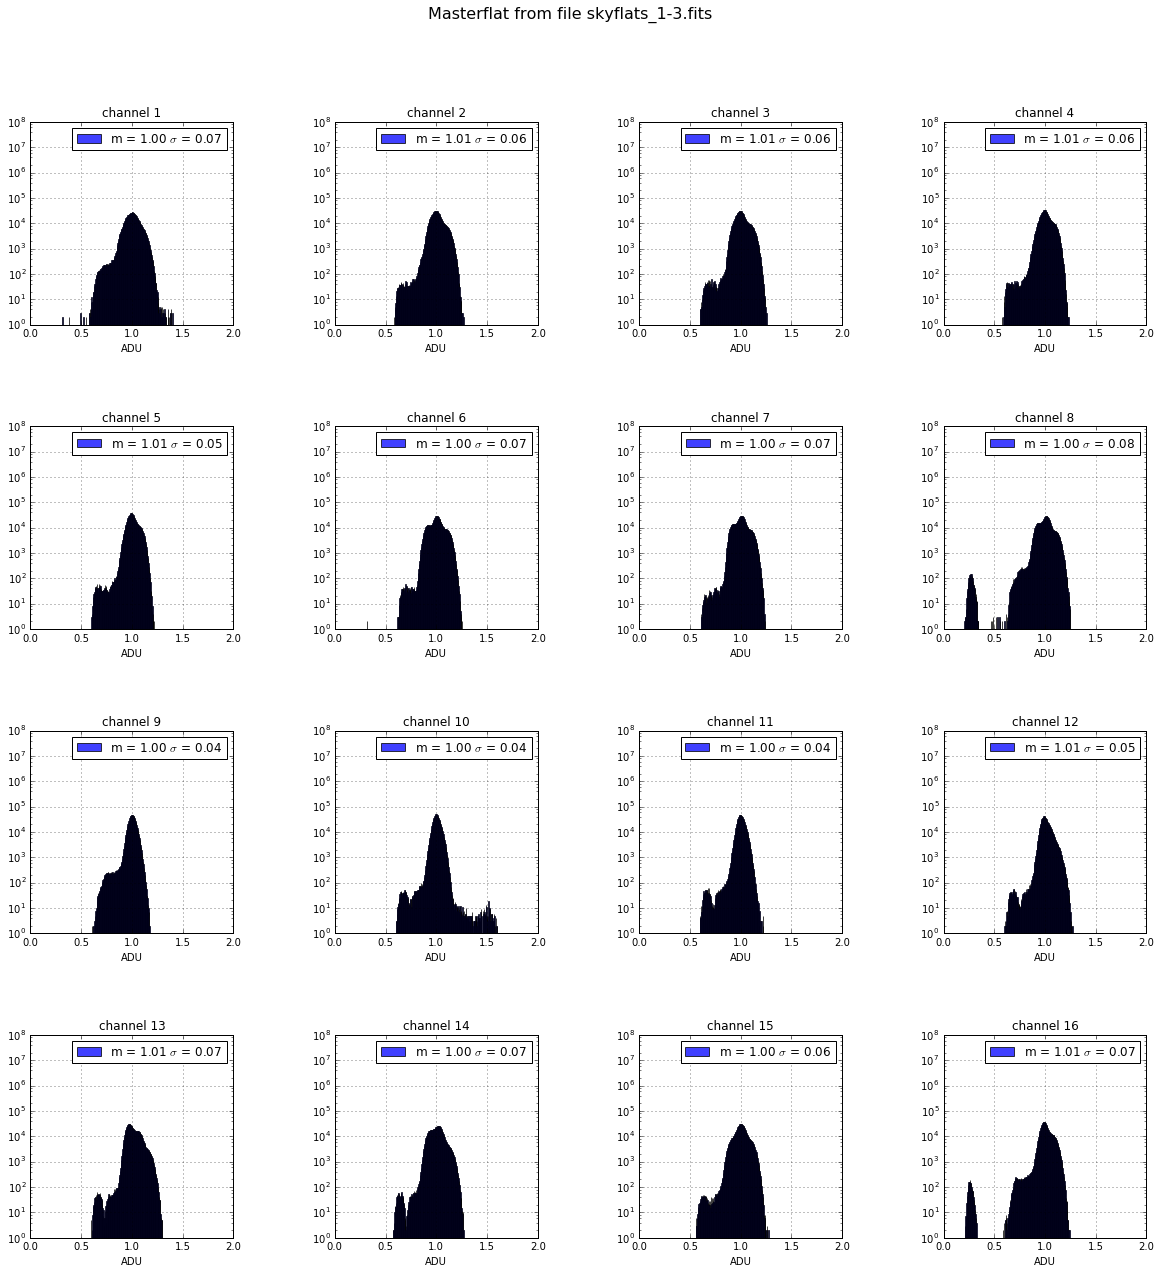

In [47]:
libMonocamBaseImages.ShowHistoSetFixedBound(masterflat_list,'Masterflat',inputfitsfilename,outputfigfilename2,Vmin=0.,Vmax=2.)